In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import networkx as nx

from sklearn.metrics import accuracy_score

from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MalNetTiny
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.transforms import LocalDegreeProfile, BaseTransform
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.transforms import Compose

In [2]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
if torch.cuda.is_available():
    print("GPU 사용중")
    divice = torch.device("cuda")
else:
    print("CPU 사용 불가능")
    divice = torch.device("cpu")

2.0.1
GPU 사용중


In [3]:
class ClosesnessCentrality(BaseTransform):
    def __init__(self, to_undirected: bool = False):
        self.to_undirected = to_undirected
        
    def __call__(self, data: Data) -> Data:
        return self.forward(data)
    
    def forward(self, data: Data) -> Data:
        
        G = to_networkx(data, to_undirected=self.to_undirected)
        closeness_centrality = nx.closeness_centrality(G)

        # 현재 노드의 closeness
        num_nodes = data.edge_index.max().item() + 1
        node_order = list(range(num_nodes))
        closeness_tensor = torch.tensor([closeness_centrality[node] for node in node_order], dtype=torch.float32).view(-1, 1)
        
        # data.x에 추가
        features_to_concat = [closeness_tensor]
        if data.x is None:  # 원래 노드 속성이 없는 경우
            data.x = torch.cat(features_to_concat, dim=-1)
        else:  # 이미 노드 속성이 있는 경우
            data.x = torch.cat([data.x] + features_to_concat, dim=-1)
        
        return data

In [4]:
# class BetweennessCentrality(BaseTransform):
#     def __init__(self, to_undirected: bool = False):
#         self.to_undirected = to_undirected

#     def __call__(self, data: Data) -> Data:
#         return self.forward(data)

#     def forward(self, data: Data) -> Data:
#         G = to_networkx(data, to_undirected=self.to_undirected)
#         betweenness_centrality = nx.betweenness_centrality(G)

#         # 현재 노드의 betweenness
#         num_nodes = data.edge_index.max().item() + 1
#         node_order = list(range(num_nodes))
#         betweenness_tensor = torch.tensor([betweenness_centrality[node] for node in node_order], dtype=torch.float32).view(-1, 1)
        
#         # 이웃 노드의 betweenness
#         max_betweenness_neighbors = []
#         min_betweenness_neighbors = []
#         avg_betweenness_neighbors = []
#         std_betweenness_neighbors = []
#         for node in node_order:
#             neighbors = list(G.neighbors(node))
#             neighbor_betweenness = [betweenness_centrality[neighbor] for neighbor in neighbors]
#             if not neighbor_betweenness:  # 이웃이 없는 경우
#                 max_betweenness, min_betweenness, avg_betweenness, std_betweenness = 0, 0, 0, 0
#             else:
#                 max_betweenness = max(neighbor_betweenness)
#                 min_betweenness = min(neighbor_betweenness)
#                 avg_betweenness = np.mean(neighbor_betweenness)
#                 std_betweenness = np.std(neighbor_betweenness)
#             max_betweenness_neighbors.append(max_betweenness)
#             min_betweenness_neighbors.append(min_betweenness)
#             avg_betweenness_neighbors.append(avg_betweenness)
#             std_betweenness_neighbors.append(std_betweenness)

#         max_betweenness_tensor = torch.tensor(max_betweenness_neighbors, dtype=torch.float32).view(-1, 1)
#         min_betweenness_tensor = torch.tensor(min_betweenness_neighbors, dtype=torch.float32).view(-1, 1)
#         avg_betweenness_tensor = torch.tensor(avg_betweenness_neighbors, dtype=torch.float32).view(-1, 1)
#         std_betweenness_tensor = torch.tensor(std_betweenness_neighbors, dtype=torch.float32).view(-1, 1)
        
#         # data.x에 추가
#         features_to_concat = [betweenness_tensor, max_betweenness_tensor, min_betweenness_tensor, avg_betweenness_tensor, std_betweenness_tensor]
#         if data.x is None:
#             data.x = torch.cat(features_to_concat, dim=-1)
#         else:
#             data.x = torch.cat([data.x] + features_to_concat, dim=-1)
        

In [5]:
HyperParams = { # data 관련
                "data_root": "./data",
                "data_transform": Compose([LocalDegreeProfile(), ClosesnessCentrality()]),
                "random_seed": 42,
                "data_split": {"train":0.8, "val":0.1, "test":0.1},
                "batch_size": 64,
                
                # model 관련
                "num_layers": 6,
                "hidden_dim": 128,
                "dropout": 0,     # (dropout 안쓰면 0)
                
                # train 관련
                "Optimizer": torch.optim.Adam,
                "learning_rate": 0.001,
                "loss_fn": torch.nn.CrossEntropyLoss(),
                "epochs": 200
}

In [6]:
dataset = MalNetTiny(root=HyperParams["data_root"], transform=HyperParams["data_transform"])

In [7]:
torch.save(dataset, "closeness.pth")

In [8]:
dataset = torch.load("closeness.pth")

In [9]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset[0].x.size(1)}')
# print(f'Number of classes: {dataset.num_classes}')
print('=============================================================')
data = dataset[0]
print(data)
print()


Dataset: MalNetTiny(5000):
Number of graphs: 5000
Number of features: 6
Data(edge_index=[2, 3576], y=[1], num_nodes=1679, x=[1679, 6])



In [10]:
torch.manual_seed(HyperParams["random_seed"])
dataset = dataset.shuffle()
num_train = int(len(dataset)*HyperParams["data_split"]["train"])
num_val = int(len(dataset)*HyperParams["data_split"]["val"])

train_dataset = dataset[:num_train]
val_dataset = dataset[num_train:num_train+num_val]
test_dataset = dataset[num_train+num_val:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing graphs: {len(test_dataset)}')

Number of training graphs: 4000
Number of validation graphs: 500
Number of testing graphs: 500


In [11]:
train_loader = DataLoader(train_dataset, batch_size=HyperParams["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=HyperParams["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HyperParams["batch_size"], shuffle=False)

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, num_layers, hidden_dim, dropout):
        super(GCN, self).__init__()
        self.args = {"num_layers":num_layers,
                    "hidden_dim":hidden_dim,
                    "dropout":dropout,
                    "num_classes":dataset.num_classes,
                    "num_features":dataset.num_features}
        
        self.layers = torch.nn.ModuleList([])
        for i in range(self.args["num_layers"]):
            if i == 0:
                self.layers.append(GCNConv(self.args["num_features"], self.args["hidden_dim"]))
            else:
                self.layers.append(GCNConv(self.args["hidden_dim"], self.args["hidden_dim"]))
        
        self.fc1 = Linear(self.args["hidden_dim"], self.args["hidden_dim"])
        self.fc2 = Linear(self.args["hidden_dim"], self.args["num_classes"])
        
    def forward(self, x, edge_index, batch):
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            x = F.relu(x)
        x = global_add_pool(x, batch)
        
        x = F.relu(self.fc1(x))
        if self.args["dropout"] > 0:
            x = F.dropout(x, p=self.args["dropout"], training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:
model = GCN(num_layers=HyperParams["num_layers"],
            hidden_dim=HyperParams["hidden_dim"],
            dropout=HyperParams["dropout"]).to(divice)
print(model)

GCN(
  (layers): ModuleList(
    (0): GCNConv(6, 128)
    (1-5): 5 x GCNConv(128, 128)
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [14]:
optimizer = HyperParams["Optimizer"](model.parameters(), lr=HyperParams["learning_rate"])
loss_fn = HyperParams["loss_fn"]

In [15]:
def train():
    model.train()
    
    loss_total = 0
    y_true, y_pred = [], []
    for data in train_loader:
        data = data.to(divice)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        pred = out.max(dim=1)[1]
        
        y_true.append(data.y.detach().cpu().numpy().tolist())
        y_pred.append(pred.detach().cpu().numpy().tolist())
        
        loss = loss_fn(out, data.y)
        loss.backward()
        loss_total += loss.item() * data.num_graphs
        optimizer.step()
    
    y_true = [y for x in y_true for y in x]
    y_pred = [y for x in y_pred for y in x]
    acc = accuracy_score(y_true, y_pred)
    return loss_total / len(train_dataset), acc

In [16]:
def test(loader):
    model.eval()
    
    loss_total = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(divice)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.max(dim=1)[1]
        
        y_true.append(data.y.detach().cpu().numpy().tolist())
        y_pred.append(pred.detach().cpu().numpy().tolist())
        
        loss = loss_fn(out, data.y)
        loss_total += loss.item() * data.num_graphs
    
    y_true = [y for x in y_true for y in x]
    y_pred = [y for x in y_pred for y in x]
    acc = accuracy_score(y_true, y_pred)
    return loss_total / len(loader.dataset), acc

In [17]:
results = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "test_loss":0, "test_acc":0}

for epoch in range(HyperParams["epochs"]):
    train_loss, train_acc = train()
    val_loss, val_acc = test(val_loader)
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\t\t', end="\r")

Test Loss: 0.2768, Test Acc: 0.9440
Best Val Acc: 0.9200 at epoch 173


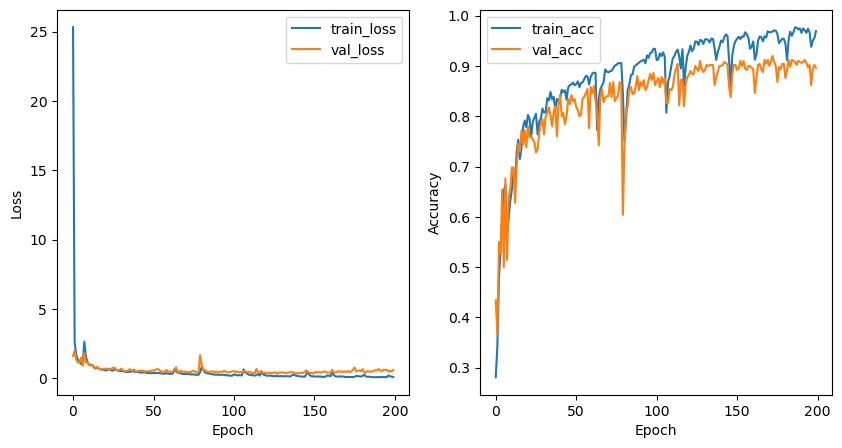

In [18]:
test_loss, test_acc = test(test_loader)
results["test_loss"] = test_loss
results["test_acc"] = test_acc

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
print(f'Best Val Acc: {max(results["val_acc"]):.4f} at epoch {results["val_acc"].index(max(results["val_acc"]))+1}')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results["train_loss"], label="train_loss")
plt.plot(results["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results["train_acc"], label="train_acc")
plt.plot(results["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
file_name = f"./saves/GCN_{str(int(results['test_acc']*1000))}_closeness.pt"
torch.save(model.state_dict(), file_name)
print(f"saved at {file_name}")

saved at ./saves/GCN_944_closeness.pt


In [21]:
# save results
import json
with open(f"./saves/GCN_{str(int(results['test_acc']*1000))}_closeness.json", "w") as f:
    json.dump(results, f)